In [2]:
import matplotlib.pyplot as plt
import polars as pl

import numpy as np
import pandas as pd

import polars as pl
import seaborn as sns

%reload_ext autoreload
%autoreload 2

In [3]:
df_train = pl.read_parquet("../experiments/datasets/master_card_basic/train.parquet")
df_train_init = df_train.clone()
df_test = pl.read_parquet("../experiments/datasets/master_card_basic/test.parquet")

In [4]:
from mastercard.models.mc_lgbm_basic import src

user_statistics, _ = src.compute_user_time_statistics(pl.concat([df_train, df_test]))
for stats in user_statistics.values():
    df_test = df_test.join_asof(stats, on="timestamp", by="user_id")
df_test, _ = src.compute_time_features(df_test)

/tmp/ipykernel_14939/636338328.py:5: UserWarning: Sortedness of columns cannot be checked when 'by' groups provided
  df_test = df_test.join_asof(stats, on="timestamp", by="user_id")


In [5]:
# import seaborn as sns

# for col in [i for i in df_train.columns if i != "is_fraud"]:
#     if len(df_train[col].unique()) > 50:
#         continue
#     fig, ax = plt.subplots(1, 1, figsize=(8, 4))

#     x = df_train.group_by(col).agg(pl.col("is_fraud").sum() / pl.col("is_fraud").len())
#     sns.scatterplot(x, x=col, y="is_fraud", ax=ax)
#     ax.axhline(df_train["is_fraud"].mean(), color="k", linestyle="--", alpha=0.3)
#     mi, ma = (
#         x["is_fraud"].min(),
#         x["is_fraud"].max(),
#     )
#     ax.set_ylim([mi * 0.8, ma * 1.2])
#     fig.tight_layout()

In [6]:

import os
import joblib
parent_id = "ce75e1aea59249e8a866f261cac9bb26"
exp_id = "6709d08612e4446e86ab2c89bdf0f221"

path = f"../experiments/artifacts/{parent_id}/{exp_id}"

In [7]:
model = joblib.load(path + "/model.joblib")

In [8]:
model.feature_names_in_

array(['passthrough__amount', 'passthrough__session_length_seconds',
       'passthrough__age_user', 'passthrough__year', 'passthrough__month',
       'passthrough__day_of_month', 'passthrough__hour_of_day',
       'passthrough__day_of_week', 'passthrough__day_of_year',
       'passthrough__week_of_year', 'passthrough__is_weekend',
       'passthrough__hour_sin', 'passthrough__hour_cos',
       'passthrough__day_of_week_cos', 'passthrough__month_cos',
       'passthrough__day_of_year_sin', 'passthrough__day_of_year_cos',
       'passthrough__is_business_hours', 'passthrough__user_id',
       'passthrough__channel', 'passthrough__currency',
       'passthrough__payment_method', 'passthrough__is_international'],
      dtype='<U35')

In [9]:
df_train = pl.read_parquet("../experiments/datasets/master_card_basic/train.parquet")
df_train_init = df_train.clone()
df_test = pl.read_parquet("../experiments/datasets/master_card_basic/test.parquet")

user_statistics, user_statistics_features = src.compute_user_time_statistics(pl.concat([df_train]))
for stats in user_statistics.values():
    df_train = df_train.join_asof(stats, on="timestamp", by="user_id")
df_train, _ = src.compute_time_features(df_train)

/tmp/ipykernel_14939/1552994851.py:7: UserWarning: Sortedness of columns cannot be checked when 'by' groups provided
  df_train = df_train.join_asof(stats, on="timestamp", by="user_id")


In [27]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

clustering_features_train = df_train[[i for i in df_train.columns if any([i.endswith(k) for k in ['hourly', 'daily', 'weekly', 'monthly', 'quarterly', 'yearly']]) ]]


pipe = make_pipeline(
    PCA(n_components=4), KMeans(10),
).fit(clustering_features_train)

In [11]:
user_statistics, _ = src.compute_user_time_statistics(pl.concat([df_train_init, df_test]))
for stats in user_statistics.values():
    df_test = df_test.join_asof(stats, on="timestamp", by="user_id")
df_test, _ = src.compute_time_features(df_test)

/tmp/ipykernel_14939/3347853506.py:3: UserWarning: Sortedness of columns cannot be checked when 'by' groups provided
  df_test = df_test.join_asof(stats, on="timestamp", by="user_id")


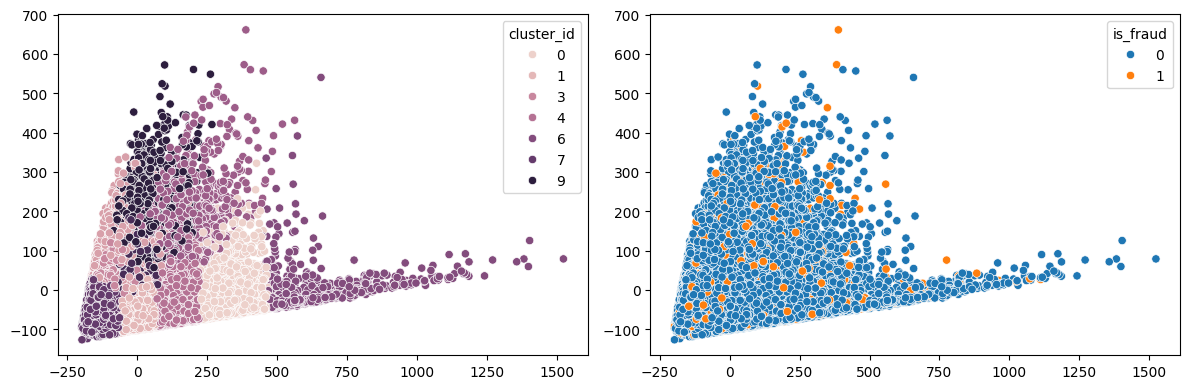

In [22]:

clustering_features_test = df_test[[i for i in df_test.columns if any([i.endswith(k) for k in ['hourly', 'daily', 'weekly', 'monthly', 'quarterly', 'yearly']]) ]]

X = pipe[0].transform(clustering_features_test)


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=pd.Series(pipe.predict(clustering_features_test), name='cluster_id'), ax=ax[0])
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=df_test['is_fraud'],ax=ax[1])

fig.tight_layout()